In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
image = 'D:/Prateek/Project_Data/kaggle dataset/archive/Images'
caption = 'D:/Prateek/Project_Data/kaggle dataset/archive/captions.txt'
working='D:/Prateek/Project_Data/kaggle dataset/archive/'

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
features = {}
directory = image

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:

pickle.dump(features, open(os.path.join(working,'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(working, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(caption), 'r') as c:
    next(c)
    captions_doc = c.read()
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [8]:
map = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in map:
        map[image_id] = []
    # store the caption
    map[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(map)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', ' ')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# preprocess the text
clean(map)

In [12]:
#taking all caption in on list
allcaptions = []
for i in map:
    for j in map[i]:
        allcaptions.append(j)

In [13]:
len(allcaptions)

40455

In [14]:
allcaptions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(allcaptions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
max_length = max(len(i.split()) for i in allcaptions)
max_length

35

In [17]:
image_ids = list(map.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq,out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [19]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
#plot_model(model, show_shapes=True)

In [20]:
# train the model
epochs = 80
batch_size = 32
steps = len(train) // batch_size
#steps used for back propagation


for i in range(epochs):
    generator = data_generator(train, map, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 33s 147ms/step - loss: 1.5110


In [21]:
# save the model
model.save(working+'best_model.h5')

C:\Users\Family\.conda\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text


In [24]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = map[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.508386
BLEU-2: 0.284083


# Visualize the Results

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(c):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = c.split('.')[0]
    img_path = directory + "/" + c
    image_show = Image.open(img_path)
    captions = map[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image_show)
   

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the cement sidewalk endseq


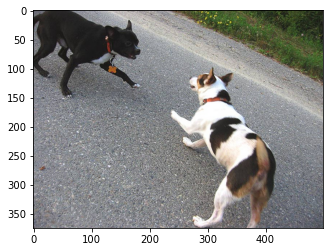

In [26]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq couple stands close at the water 's edge endseq
startseq the two people stand by body of water and in front of bushes in fall endseq
startseq two people hold each other near pond endseq
startseq two people stand by the water endseq
startseq two people stand together on the edge of the water on the grass endseq
--------------------Predicted--------------------
startseq couple walking across the stream in fall endseq


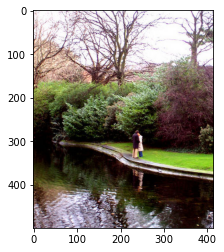

In [27]:

generate_caption("3637013_c675de7705.jpg")

---------------------Actual---------------------
startseq four wheel drive car is navigating along rocky off road trail endseq
startseq jeep sidewalks on some rocks endseq
startseq red jeep hangs from the edge of rocky cliff as girl looks on endseq
startseq red truck is driving over rocky surface endseq
startseq woman stands next to red suv that has run off into ditch endseq
--------------------Predicted--------------------
startseq person drives rocky cliff endseq


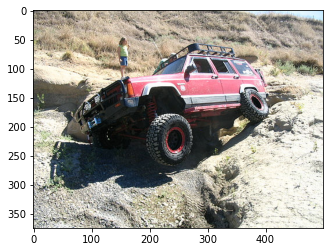

In [28]:
generate_caption("36422830_55c844bc2d.jpg")

---------------------Actual---------------------
startseq soccer player in blue is chasing after the player in black and white endseq
startseq the girl in the white strip is falling down as the girl in the blue strip challenges for the soccer ball endseq
startseq the girls are playing soccer endseq
startseq two women in soccer uniforms playing soccer endseq
startseq two young women on different teams are playing soccer on field endseq
--------------------Predicted--------------------
startseq two men playing sport on field hockey endseq


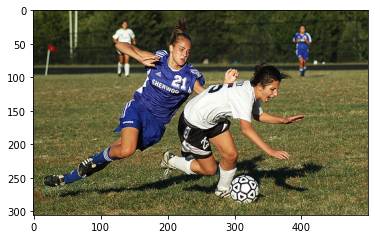

In [29]:
generate_caption("47871819_db55ac4699.jpg")